**librarys**

In [604]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
import seaborn as sns
# import plotly.express as px
import random

from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
# from xgboost import XGBClassifier

faults_type_dic = {0: "SERIE", 1: "EXCITACAO"}

rcParams = {'figure.figsize': (15 ,8)}
sns.set(rc=rcParams)
sns.set(font_scale=1.6)

**1- Business Problem**

O problema de negócio consise na classificação de tipo da falta e sua localizacao com ocorrência em um transformador de deslocamento de Fase indireto Assimétrico (ISPST)


Transformadores de Deslocamento de Fase (PSTs) foram introduzidos pela primeira vez em 1930 para resolver problemas de fluxo de energia. Desde então tem sido um componente integral do sistema de energia. Os PSTs são usados para obter a diferença de fase necessária entre a tensão final de envio e tensão final de recepção. Eles podem controlar o fluxo de energia ativa em ramos de redes em malha e conectar redes independentes em um único sistema de energia de linha de transmissão alterando o ângulo de fase. Os PSTs inserem uma variável de tensão de quadratura para a tensão de fase da fonte que é obtida das tensões fase-fase das duas fases restantes e, realizam assim, a mudança de fase necessária (Shailendra Kumar Bhasker, diferencial protection). O controle do fluxo de potência utilizado pelo PST é dado por (1)

p=  (|Vs||Vl|)/Xt  sin⁡〖(δ ± Δθ)〗	(1)

Existem diferentes tipos de PSTs, de acordo com sua construção como discutido em [1]. O PST indireto simétrico (ISPST) é amplamente utilizado devido à sua construção simples, como mostrado na Fig. 1. Este equipamento auxilia na utilização de linhas de transmissão de energia que melhoram o desempenho e eficiência operacional do sistema



Quanto ao tipo os transientes podem ser de superexcitação, Magnetizacao inrush, sympathetic inrush, External Faults.

Quanto a localização da Falta pode ser em sua unidade de serie ou excitacao

**Hipoteses**: 

- **1- Correntes muito altas tendem a ter tido uma falta**
- **2- Em uma falta há um afundamento de tensão**

**2-Coleta**

The files - ’fault_location_pha’, ’fault_location_phb’, and ’fault_location_phc’ have phase a,b,c differential currents for 46872 cases. Each row has 167 samples (one cycle).

 In fault_location_target’- the first 33480 are faults in series unit, next 13392 are faults in exciting unit.

In [605]:
! pwd

/c/Users/felipe/Desktop/Github/machine-learning-projects/Fault Transformers Classification Problem


## Localização da Falta

In [606]:
pd.read_csv("data/fault_location_target.csv", names=["location"], header=0)

,location
0,1
1,1
2,1
3,1
4,1
...,...
46867,2
46868,2
46869,2
46870,2


In [607]:
# 46872 casos de falta - cada linha com 167 amostras (um ciclo) -
cols = np.arange(0, 167)
loc_feats_df = pd.read_csv("data/fault_location_pha.txt", names=cols)
fault_loc_target_df = pd.read_csv("data/fault_location_target.csv", names=["location"], header=0)
fault_loc_df = pd.concat([fault_loc_target_df,loc_feats_df], axis=1)
fault_loc_df.head()

,location,0,1,2,3,4,5,6,7,8,...,157,158,159,160,161,162,163,164,165,166
0,1,0.815070,-5.4644,-5.8340,-6.3207,-6.8369,-7.3216,-7.8296,-7.5270,-7.0252,...,3.5267,2.9864,2.4774,1.9988,1.5388,1.0788,0.59762,0.07691,-0.49434,-1.1175
1,1,0.038560,-7.7295,-7.8449,-8.0760,-8.3711,-8.5972,-8.8602,-8.2476,-7.4661,...,-3.5159,-3.9069,-4.2947,-4.6804,-5.0649,-5.4488,-5.83190,-6.21360,-6.59300,-6.9691
2,1,0.053292,-7.7204,-7.8411,-8.0764,-8.3754,-8.6054,-8.8722,-8.2697,-7.4949,...,-3.4873,-3.8819,-4.2738,-4.6641,-5.0537,-5.4429,-5.83110,-6.21760,-6.60130,-6.9813
3,1,0.074772,-7.6941,-7.8224,-8.0637,-8.3677,-8.6032,-8.8752,-8.2891,-7.5255,...,-3.4377,-3.8372,-4.2346,-4.6310,-5.0272,-5.4229,-5.81740,-6.20960,-6.59840,-6.9830
4,1,0.095511,-7.6574,-7.7953,-8.0445,-8.3549,-8.5971,-8.8756,-8.3117,-7.5643,...,-3.3752,-3.7806,-4.1847,-4.5885,-4.9923,-5.3956,-5.79720,-6.19600,-6.59090,-6.9811


In [608]:
#  the first 33480 are faults in series unit, next 13392 are faults in exciting unit.
# Serie unit - 1
# Exciting unit - 2
fault_loc_target_df.value_counts()

location
1           33480
2           13392
dtype: int64

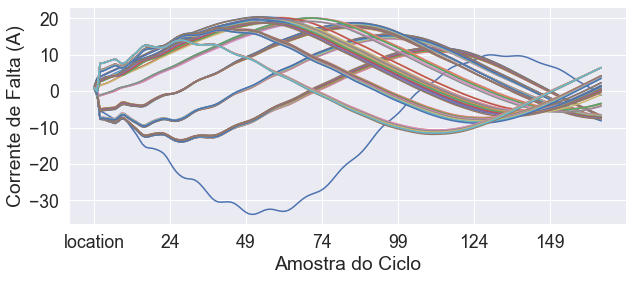

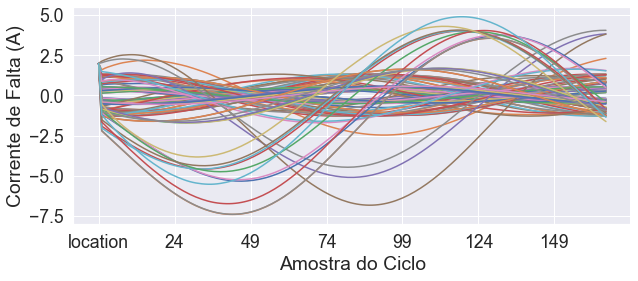

In [609]:
# Verificando algumas Faltas
# 1- Falta na unidade em serie
# 2- Falsa na unidade de excitacao
for type in fault_loc_df.location.unique():
    fig, ax = plt.subplots(1, figsize=(10,4))
    for i in range(0, 100):
        fault_loc_df[fault_loc_df.location == type].iloc[i].plot(ax=ax)
        #ax.set_title(type)
        ax.set_ylabel("Corrente de Falta (A)")
        ax.set_xlabel("Amostra do Ciclo")

## Preprocess

In [610]:
df = fault_loc_df.copy()

In [611]:
df.shape[0]

46872

In [612]:
df.isnull().sum().sum()

0

In [613]:
# Metricas Gerais
df.describe()

,location,0,1,2,3,4,5,6,7,8,...,157,158,159,160,161,162,163,164,165,166
count,46872.000000,46872.000000,46872.000000,46872.000000,46872.000000,46872.000000,46872.000000,46872.000000,46872.000000,46872.000000,...,46872.000000,46872.000000,46872.000000,46872.000000,46872.000000,46872.000000,46872.000000,46872.000000,46872.000000,46872.000000
mean,1.285714,0.001444,0.007564,0.007758,0.007837,0.007899,0.007923,0.008035,0.007035,0.005750,...,-0.029785,-0.028850,-0.027934,-0.027026,-0.026116,-0.025189,-0.024252,-0.023344,-0.022507,-0.021734
std,0.451759,1.025189,2.026893,2.160709,2.287039,2.428465,2.560564,2.712789,2.755182,2.803827,...,2.047130,1.995367,1.958345,1.936309,1.930515,1.942924,1.975388,2.028565,2.101141,2.189884
min,1.000000,-5.363100,-8.113000,-8.352000,-8.722600,-9.134000,-9.499700,-9.890400,-9.116700,-8.590300,...,-11.891000,-11.830000,-11.742000,-11.625000,-11.480000,-11.305000,-11.434000,-11.615000,-11.769000,-11.896000
25%,1.000000,-0.524432,-0.791663,-0.833950,-0.870080,-0.889347,-0.904622,-0.933972,-0.944793,-0.962008,...,-0.822892,-0.808872,-0.798475,-0.795255,-0.794900,-0.785467,-0.772262,-0.789728,-0.814958,-0.834640
50%,1.000000,0.001171,0.001831,0.003994,0.003976,0.004985,0.005053,0.006499,0.007456,0.002829,...,-0.004661,-0.004331,-0.004847,-0.002822,0.000434,0.000147,0.000781,-0.000050,-0.000310,-0.000971
75%,2.000000,0.521405,0.801652,0.842362,0.876455,0.906785,0.915465,0.934555,0.946668,0.967788,...,0.792085,0.782200,0.777260,0.772580,0.773637,0.767487,0.756050,0.769853,0.791147,0.819210
max,2.000000,4.727500,8.059700,8.308200,8.687500,9.104500,9.475000,9.869000,9.103900,8.551300,...,9.766600,9.737300,9.677300,9.586300,9.464200,9.516600,9.699000,9.860700,10.006000,10.155000


In [614]:
# Apesar de duplicados, manter pois podem ser condicoes de corrente iguais em ciclos diferentes. Aqui se tiverem
# menos de 1% da base manter
print(df[df.duplicated()].shape[0])

325


In [615]:
df.location.unique()

array([1, 2], dtype=int64)

In [616]:
# Troca as features de Descricao location
df["desc_location"] = np.where(df["location"] == 1, "SERIE", "EXCITACAO")
df["desc_location"].value_counts()

SERIE        33480
EXCITACAO    13392
Name: desc_location, dtype: int64

## Feature Enginnering

Como pode ser visto, as curvas de corrente tem caracteristicas especificas em cada localizacao e tipo de falta.Dessa forma, para conseguir separar cada caso e tipo, vamos procurar por caracteristicas especificas em cada caso
que façam com o modelo consiga separa-los e identificar cada um. Vamos utilizar nesse caso algumas features:

- **Características Estatísticas: Média, mediana, máximo / minimo (amplitude de pico e vale) - Primeira Tentativa**
- **FFT - Transformada Rápida de Fourier - Segunda Tentativa**

**Location**

**Variaveis Estatistica** - Meidia, mediana, desvio padrao, maximo e minimo

In [617]:
features  = range(0, 167)

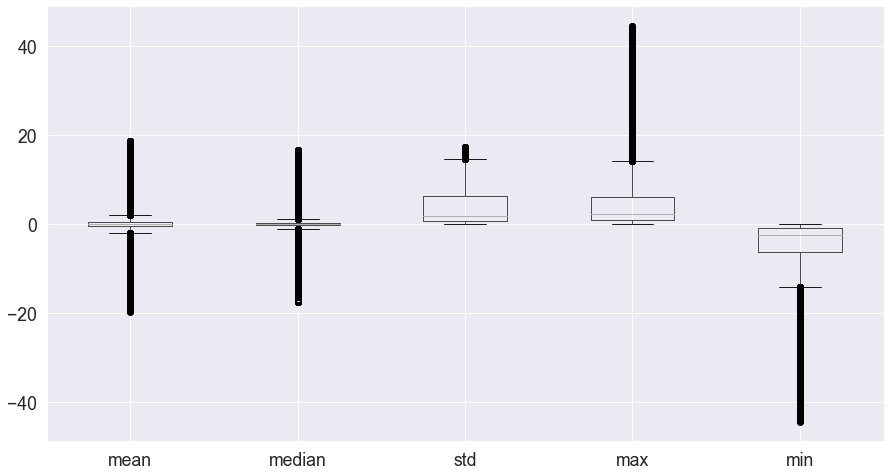

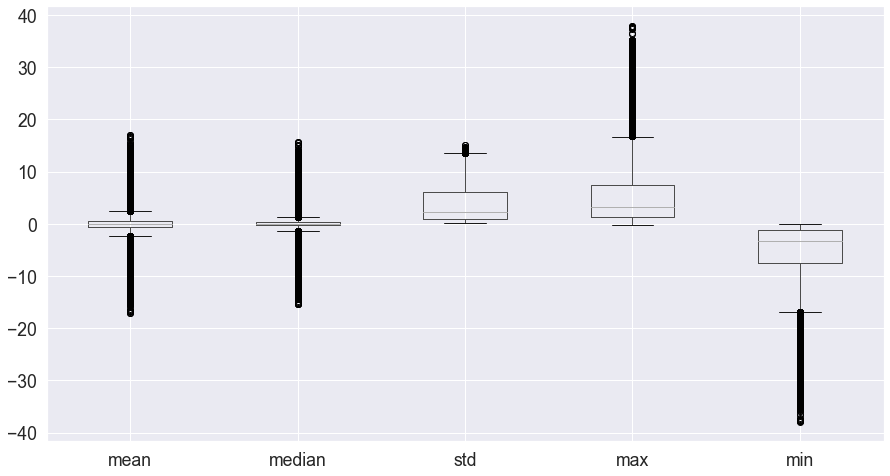

In [618]:
df["mean"] = df[features].mean(axis=1) # Axis 1 - colunas - 0 - linhas
df ["median"] = df[features].median(axis=1)
df ["std"] = df[features].std(axis=1)
df ["max"] = df[features].max(axis=1)
df ["min"] = df[features].min(axis=1)
# A Curtose ou achatamento também é uma medida que nos ajuda a dar forma à distribuição dos dados.
# A curtose, diferente da assimetria, tenta capturar em uma medida a forma das caudas da distribuição.
df ["Kurtosis"] = df[features].skew(axis=1)
df ["skew"] = df[features].kurtosis(axis=1)

for tp in df.location.unique():
    fig, ax = plt.subplots(1)
    df[df.location == tp][["mean", "median", "std", "max", "min"]].boxplot(ax=ax)

**FFT analysis - Transformada rapida de fourier**

O método de Fourier é uma técnica para o estudo de sinais que tem sido muito utilizada na ciência e na engenharia. A técnica consiste na transformação de um domínio em um outro domínio, em que muitas características do sinal analisado são revelados. O domínio transformado é denominado domínio espectral ou frequencial, enquanto o domínio original da função é chamado de domínio temporal ou domínio espacial.

Na teoria de Fourier incluem-se a transformada de Fourier e a série de Fourier. A série de Fourier é usada para analisar funções que são periódicas enquanto a transformada de Fourier é usada para representar funções aperiódicas. A transformada de Fourier pode ser vista como uma extensão da série de Fourier em que uma função aperiódica é considerada periódica no intervalo [-L∕2,L∕2], com L tendendo a infinito. Maiores detalhes podem ser obtidos em [12].

Como a transformada wavelet é muito similar à transformada de Fourier em muitos aspectos, nesta seção faz-se uma breve revisão desta transformada.

A transformada de Fourier de um sinal f, de uma variável real t, é definida pela integral



Performs a continuous wavelet transform on data, using the wavelet function. A CWT performs a convolution with data using the wavelet function, which is characterized by a width parameter and length parameter

A better approach for analyzing signals with a dynamical frequency spectrum is the Wavelet Transform. The Wavelet Transform has a high resolution in both the frequency- and the time-domain. It does not only tell us which frequencies are present in a signal, 

https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch04.html

In [619]:
# Use the fast fourier to get the max frequency on signal

C:\Users\felipe\miniconda3\envs\data_science\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\felipe\miniconda3\envs\data_science\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


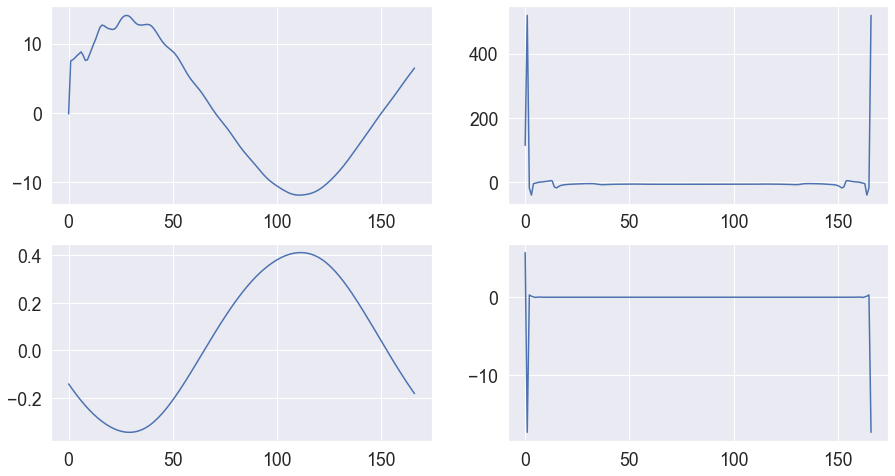

In [620]:
x_1 = df[features][df.location == 1].iloc[random.randint(0, 100)].values
x_2 = df[features][df.location == 2].iloc[random.randint(0, 100)].values
fft_x_1 = np.fft.fft(x_1)
fft_x_2 = np.fft.fft(x_2)

fig, ax = plt.subplots(2, 2)
ax[0][0].plot(x_1)
ax[0][1].plot(fft_x_1)
ax[1][0].plot(x_2)
ax[1][1].plot(fft_x_2)

0.0


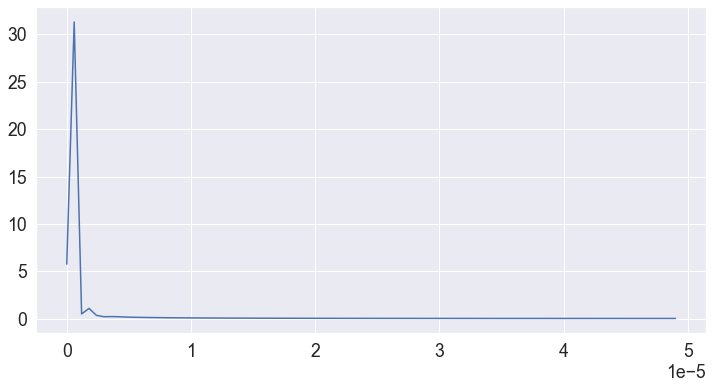

In [621]:
X = np.fft.fft(x_2)
N = len(X)
n = np.arange(N)

sr = 1 / ((60) *167)
T = N/sr
freq = n/T

# Get the one-sided specturm
n_oneside = N//2
# get the one side frequency
f_oneside = freq[:n_oneside]

plt.figure(figsize = (12, 6))
plt.plot(f_oneside, np.abs(X[:n_oneside]), 'b')
print(freq[np.argmax(X)])

# t_h = 1/f_oneside / (60)
# plt.plot(t_h, np.abs(X[:n_oneside]), 'b')

In [622]:
def apply_fft(serie):
    # Returna a frequencia maxima na serie
    fft = np.fft.fft(serie)
    fft = np.real(fft)
    
    sr = 1 / ((60) *167)
    T = N/sr
    freq = n/T
    max_freq_amplit = freq[np.argmax(fft)]

    return max_freq_amplit

In [623]:
df["fft"] = df[range(0, 167)].apply(apply_fft, axis=1)
df["fft"]

0        5.976072e-07
1        9.800758e-05
2        1.792822e-06
3        1.792822e-06
4        1.792822e-06
             ...     
46867    5.976072e-07
46868    5.976072e-07
46869    5.976072e-07
46870    5.976072e-07
46871    9.920279e-05
Name: fft, Length: 46872, dtype: float64

<AxesSubplot:xlabel='location', ylabel='fft'>

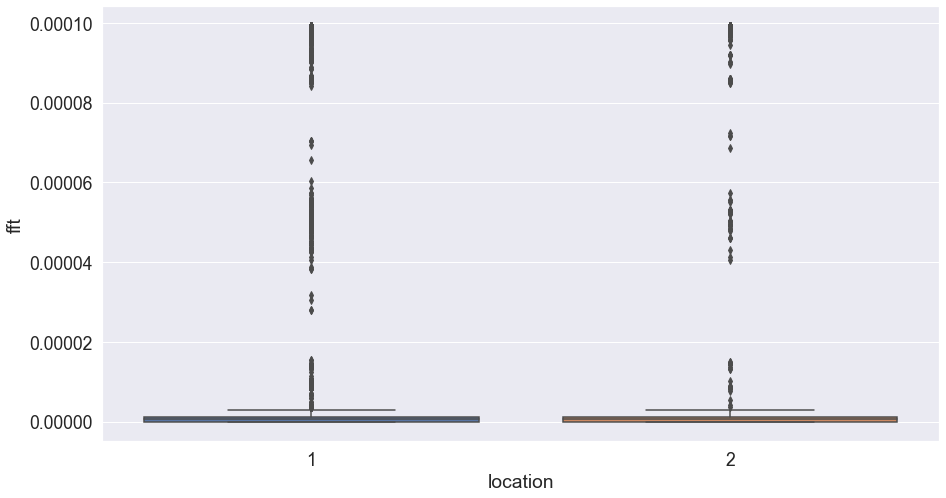

In [624]:
sns.boxplot(data=df[["fft", "location"]], x= "location", y="fft")

Separa as features que serao usadas

In [625]:
train_df = df.copy()

In [626]:
features = ["mean", "median", "std", "max", "min", "fft", "Kurtosis", "skew"]
target = "location"

train_df = train_df[features + [target]]
train_df.head()

,mean,median,std,max,min,fft,Kurtosis,skew,location
0,-10.839680,-9.67660,15.319844,9.9692,-33.892,5.976072e-07,-0.080910,-1.498335,1
1,-1.239025,-1.28020,8.240125,10.8530,-13.866,9.800758e-05,0.011770,-1.409010,1
2,-1.129139,-1.10980,8.330989,11.0890,-13.888,1.792822e-06,0.011835,-1.410871,1
3,-0.998166,-0.94920,8.435505,11.3710,-13.908,1.792822e-06,0.012454,-1.413203,1
4,-0.856066,-0.85432,8.552505,11.6850,-13.935,1.792822e-06,0.013418,-1.415851,1


**Correlacao**

Para um problema binario talvez nao faça sentido medir a correlacao. Pois a correlacao eh uma metrica que indica que quando uma variavel aumenta a outra aumenta tambem. Para esse problema

In [627]:
# train_df.corr()["location"]

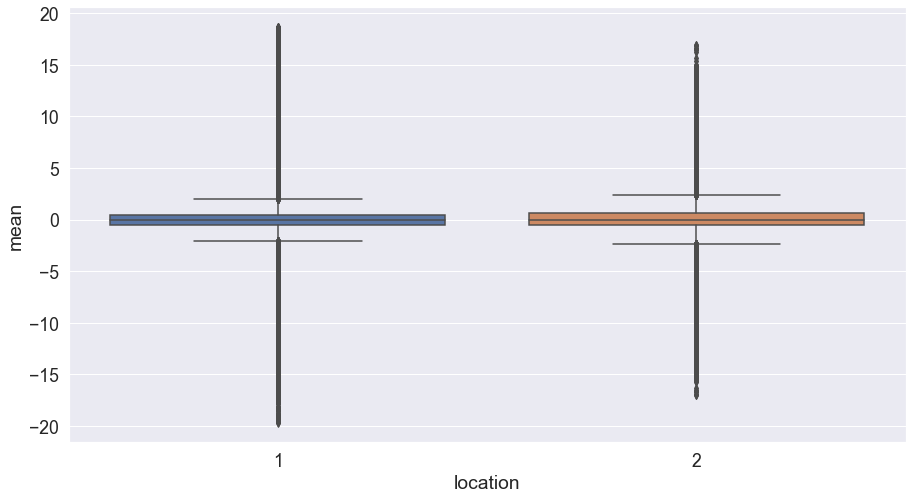

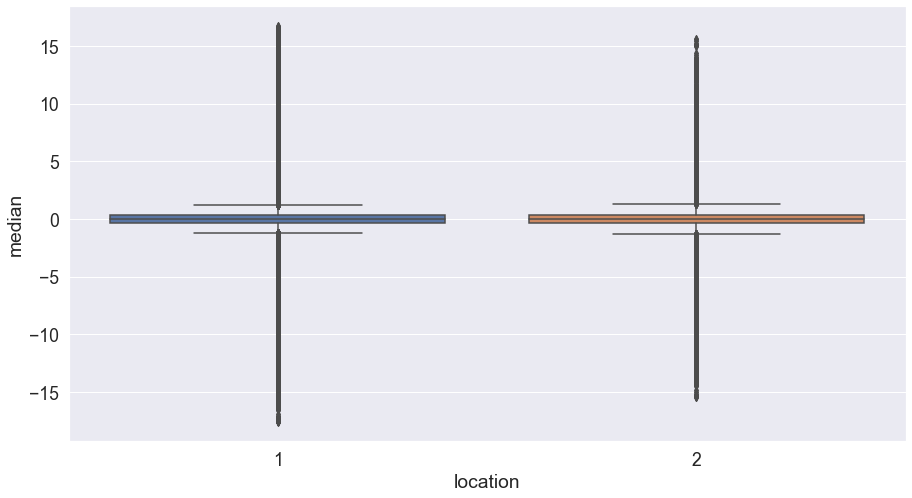

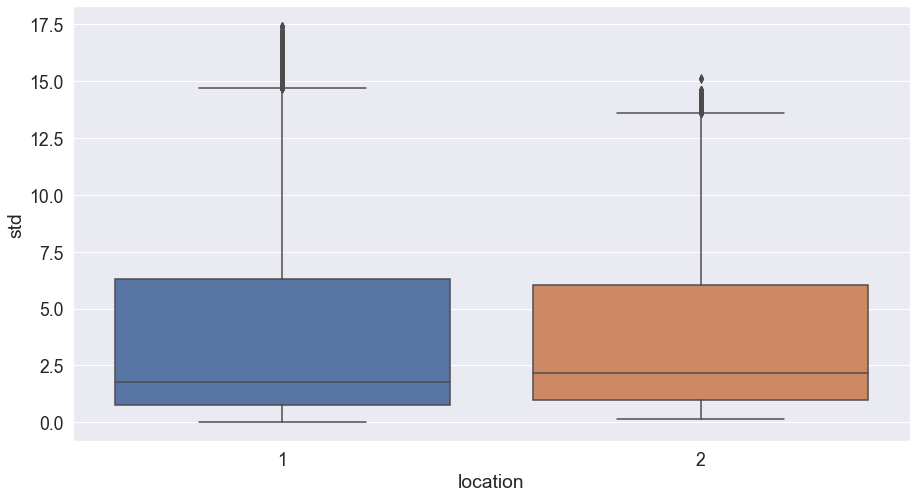

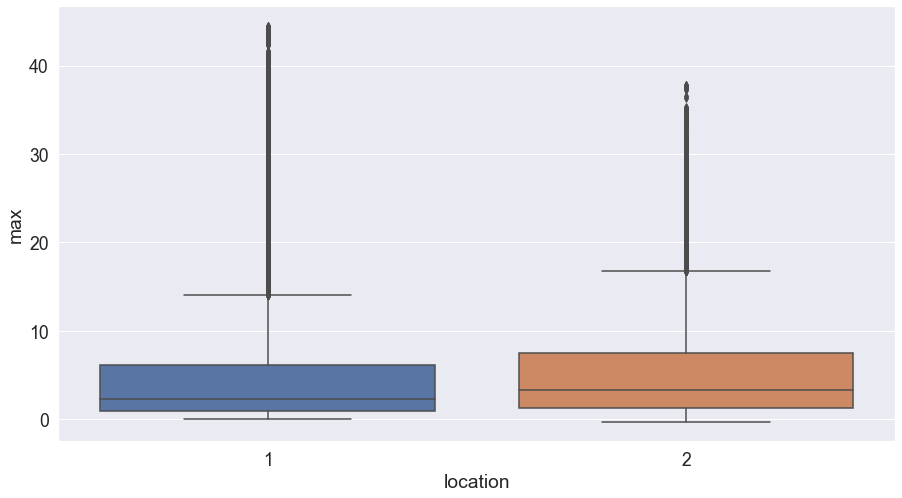

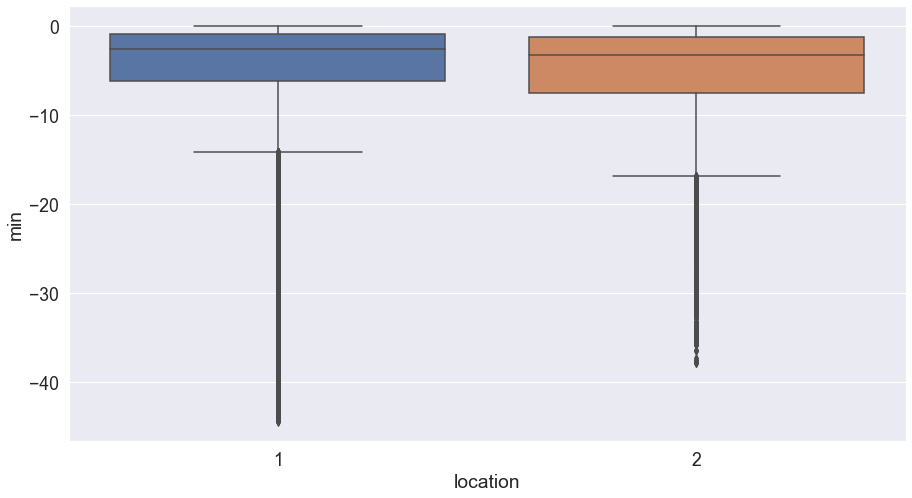

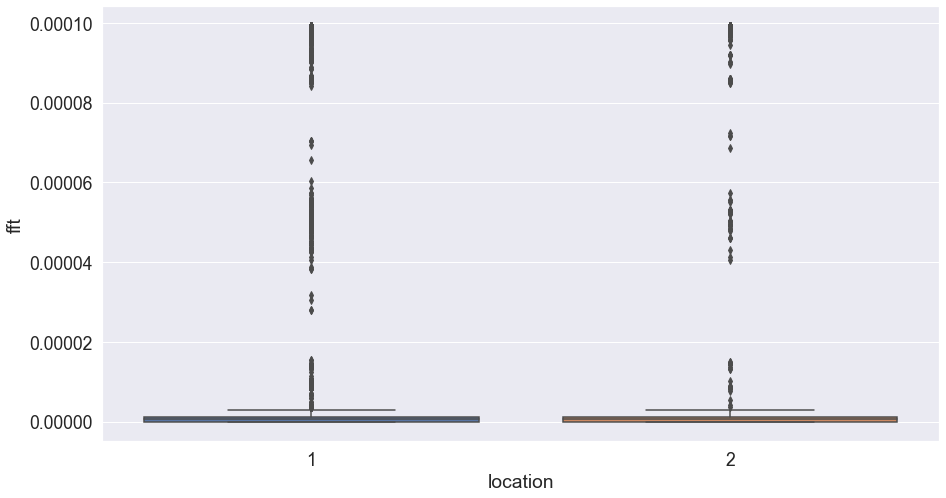

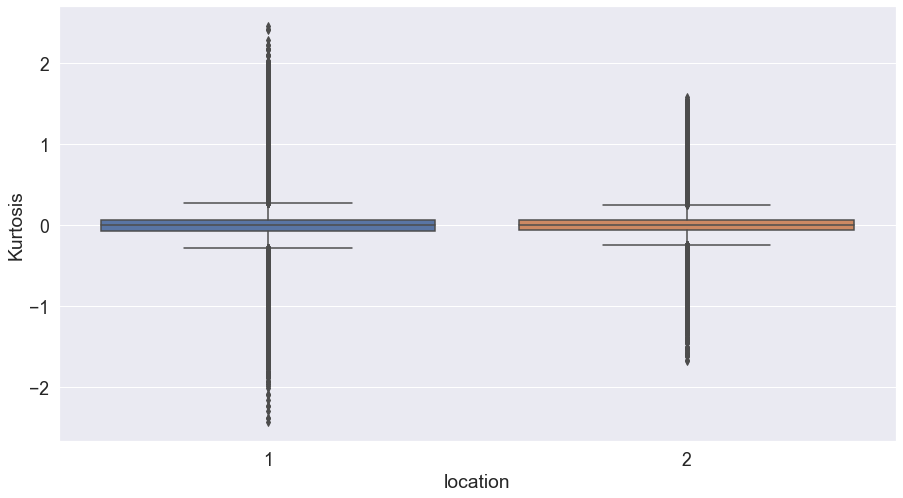

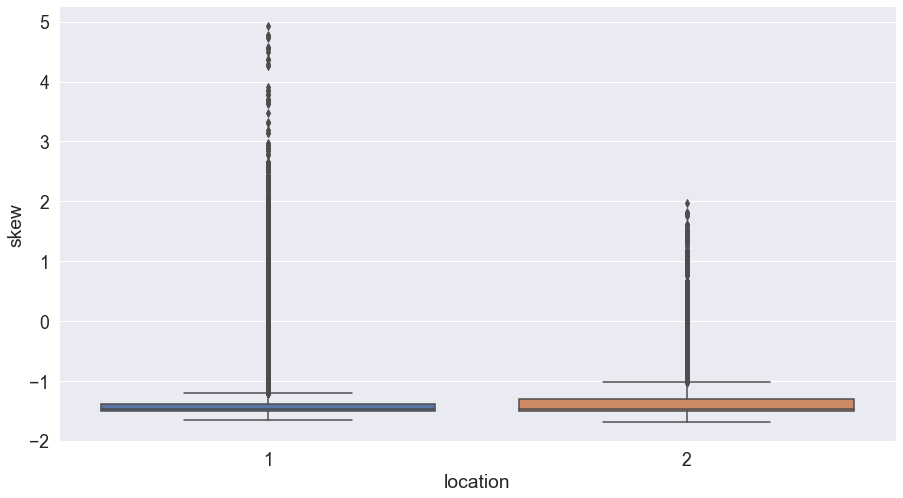

In [628]:
for column in train_df.columns:
    if column != "location":
        ax, _ = plt.subplots()
        ax = sns.boxplot(x="location", y=column, data=train_df)

In [629]:
from sklearn.preprocessing import StandardScaler

pradroniza as variaveis para o modelo

In [630]:
sc = StandardScaler()
train_df[features] = sc.fit_transform(train_df[features])
train_df

,mean,median,std,max,min,fft,Kurtosis,skew,location
0,-2.209682,-2.147621,2.376858,0.451263,-3.205408,-0.488040,-0.166590,-0.459616,1
1,-0.246815,-0.278489,0.867727,0.553595,-0.891409,2.025894,0.051689,-0.296719,1
2,-0.224349,-0.240556,0.887096,0.580920,-0.893951,-0.457194,0.051841,-0.300112,1
3,-0.197571,-0.204804,0.909374,0.613572,-0.896262,-0.457194,0.053301,-0.304365,1
4,-0.168518,-0.183683,0.934314,0.649929,-0.899382,-0.457194,0.055569,-0.309195,1
...,...,...,...,...,...,...,...,...,...
46867,-0.765488,-0.869076,-0.000157,-0.450215,-0.403165,-0.488040,0.127154,-0.462685,2
46868,-0.715228,-0.817675,0.003744,-0.417644,-0.377086,-0.488040,0.153443,-0.461447,2
46869,-0.377658,-0.518285,-0.018984,-0.246952,-0.167097,-0.488040,0.214377,-0.500261,2
46870,-0.480576,-0.531286,-0.028396,-0.314629,-0.227911,-0.488040,0.066054,-0.478499,2


<AxesSubplot:>

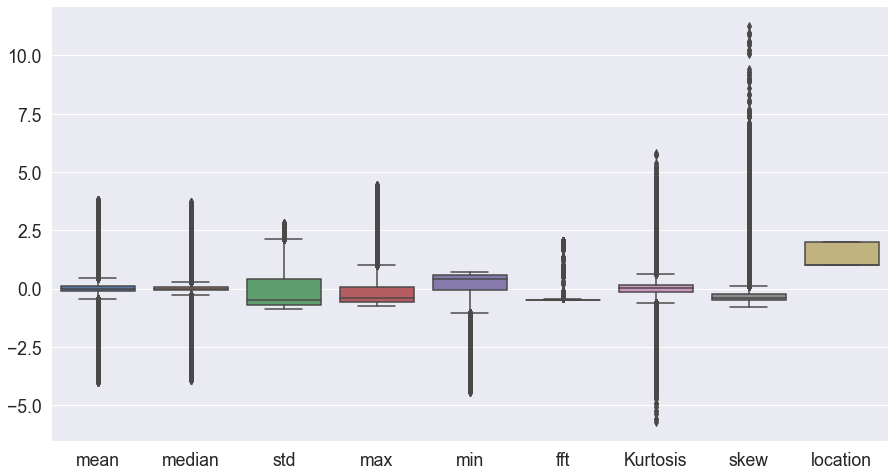

In [631]:
sns.boxplot(data=train_df)

In [632]:
train_df.sample()

,mean,median,std,max,min,fft,Kurtosis,skew,location
23108,-0.15988,-0.196018,-0.538568,-0.515229,0.356309,-0.48804,0.320654,-0.33291,1


## Prepara o conjunto para os algoritmos

In [633]:
train_df.head()

,mean,median,std,max,min,fft,Kurtosis,skew,location
0,-2.209682,-2.147621,2.376858,0.451263,-3.205408,-0.488040,-0.166590,-0.459616,1
1,-0.246815,-0.278489,0.867727,0.553595,-0.891409,2.025894,0.051689,-0.296719,1
2,-0.224349,-0.240556,0.887096,0.580920,-0.893951,-0.457194,0.051841,-0.300112,1
3,-0.197571,-0.204804,0.909374,0.613572,-0.896262,-0.457194,0.053301,-0.304365,1
4,-0.168518,-0.183683,0.934314,0.649929,-0.899382,-0.457194,0.055569,-0.309195,1


In [634]:
# Separe Dataset
test_size=0.2

features = train_df.drop(columns="location")
target = train_df["location"].replace({1:0, 2:1})

# Train and Validation set

# Deprecates: Using train_test_split
# num_val_samples = int(len(features) * 0.2)
# train_features = features[:-num_val_samples]
# train_target = target[:-num_val_samples]
# val_features = features[-num_val_samples:]
# val_target = target[-num_val_samples:]


train_features, val_features, train_target, val_target = train_test_split(features, target, test_size=test_size)

print("Number of traning samples", len(train_features))
print("Number of validation samples", len(val_features))
print("Number of features", train_features.shape[1], train_features.columns)

Number of traning samples 37497
Number of validation samples 9375
Number of features 8 Index(['mean', 'median', 'std', 'max', 'min', 'fft', 'Kurtosis', 'skew'], dtype='object')


## Modelagem

**Tensor Flow**

In [635]:
train_target

10217    0
5077     0
24308    0
38040    1
14017    0
        ..
2132     0
46217    1
33927    1
8825     0
5144     0
Name: location, Length: 37497, dtype: int64

In [636]:
# Installing Tensorflow
# import sys
# !{sys.executable} -m pip install tensorflow
from tensorflow import keras
from keras.callbacks import History 

In [637]:
np.unique(train_target)

array([0, 1], dtype=int64)

In [638]:
# Prepare train and validation set - Tensorflow needs arrays
train_features, val_features = train_features.values, val_features.values
train_target, val_target = train_target.values.reshape(-1, 1), val_target.values.reshape(-1, 1)

In [639]:
# analyze class imbalance
class_train_count = np.bincount(train_target[:, 0])
class_valid_count = np.bincount(val_target[:, 0])

print(train_target[0, 0])
# print(counts)
print("Quantidade de faltas no dataset de treino", class_train_count[0])
print("Porcentagem  de Faltas na uniidade Serie" ,round(class_train_count[0] / (class_train_count[0] + class_train_count[1])*100, 1 ), "%" )
print("Quantidade de faltas no dataset de validacao", class_valid_count[0])
print("Porcentagem  de Faltas na uniidade Serie" , round(class_valid_count[0] / (class_valid_count[0] + class_valid_count[1])*100, 1 ), "%" )

0
Quantidade de faltas no dataset de treino 26700
Porcentagem  de Faltas na uniidade Serie 71.2 %
Quantidade de faltas no dataset de validacao 6780
Porcentagem  de Faltas na uniidade Serie 72.3 %


In [640]:
# Normalize the data using traning set statistics

mean = np.mean(train_features, axis=0)
train_features -= mean
val_features -= mean
std = np.std(train_features, axis=0)
train_features /= std
val_features /= std

print("train_features", train_features)
print("val_features", val_features)
print("train_target", train_target)
print("val_target", val_target)

train_features [[-8.01547655e-02 -5.92232038e-03 -6.74126499e-01 ... -4.73051447e-01
  -3.13827023e+00  3.02716018e+00]
 [ 2.78156697e+00  2.76468727e+00  2.20109822e+00 ... -5.03885816e-01
   3.36851957e-01 -4.50077443e-01]
 [ 8.76390147e-03 -4.54571261e-04 -7.45014811e-01 ...  2.05536677e+00
   1.00921557e-01 -5.21404429e-01]
 ...
 [-5.23934553e-01 -6.07146873e-01  1.05939967e-02 ... -4.88468631e-01
   2.37043861e-01 -3.66108021e-01]
 [ 3.24964417e+00  3.24304037e+00  2.10428547e+00 ... -5.03885816e-01
   3.66809227e-01 -2.87656607e-01]
 [ 3.99325758e-01  1.61988944e-01  2.24953328e+00 ... -5.03885816e-01
   1.05579935e-01 -4.51576481e-01]]
val_features [[-3.44624712e-02 -6.09136607e-04 -2.24654646e-01 ...  2.05536677e+00
  -1.13589407e-02 -3.68985099e-01]
 [ 4.61613844e-02  6.55811974e-04 -7.43625586e-01 ... -5.03885816e-01
   2.73548265e+00  2.83498517e+00]
 [-1.43700522e-01  1.66531032e-02 -5.73932664e-01 ...  2.05536677e+00
  -2.73405917e+00  1.73251526e+00]
 ...
 [ 7.26001645e-0

In [656]:
# Criacao do modelo no Keras
# Camada Densa: foram criadas camadas densas. As camadas densas sao camadas totalmente conectadas. Ou seja, todos os neuronios
# de uma camada se conectam com todos os neuronios das camadas seguintes
# Dropout: o dropout eh uma tecnica de regularizacao utilizada para reduzir o sobreajuste em redes neurais
# Sequencial Model: https://keras.io/guides/sequential_model/
# In keras sequencial model is to plain stack of layers where each layer has exactly one input tensor and one output tensor
units = 256
output_shape = 1
model = keras.Sequential(

    [
        keras.layers.Dense(
            units, activation="relu", input_shape=(train_features.shape[-1] ,)
        ),
        keras.layers.Dense(units, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(units, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(output_shape, activation="sigmoid")
    ]
)

model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_79 (Dense)            (None, 256)               2304      
                                                                 
 dense_80 (Dense)            (None, 256)               65792     
                                                                 
 dropout_40 (Dropout)        (None, 256)               0         
                                                                 
 dense_81 (Dense)            (None, 256)               65792     
                                                                 
 dropout_41 (Dropout)        (None, 256)               0         
                                                                 
 dense_82 (Dense)            (None, 1)                 257       
                                                                 
Total params: 134,145
Trainable params: 134,145
Non-t

In [642]:
# Criando Metricas - para o treinamento do modelo
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# Keras dont have build-in f1 score, have to be created
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

**Treinando com a funcao de perda RMSE**

In [643]:
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.BinaryAccuracy(name="accuracy"),
    f1_m
]

model.compile(optimizer=keras.optimizers.Adam(1e-2), loss="MeanSquaredError", metrics=metrics)

model.fit(
    train_features,
    train_target,
    batch_size=2048,
    epochs=40,
    verbose=2,
    validation_data=(val_features, val_target)
)

Epoch 1/40
19/19 - 2s - loss: 0.2160 - fn: 9975.0000 - fp: 1965.0000 - tn: 24735.0000 - tp: 822.0000 - precision: 0.2949 - recall: 0.0761 - accuracy: 0.6816 - f1_m: 0.0629 - val_loss: 0.1925 - val_fn: 2595.0000 - val_fp: 0.0000e+00 - val_tn: 6780.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.7232 - val_f1_m: 0.0000e+00 - 2s/epoch - 111ms/step
Epoch 2/40
19/19 - 0s - loss: 0.1953 - fn: 10797.0000 - fp: 2.0000 - tn: 26698.0000 - tp: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - accuracy: 0.7120 - f1_m: 0.0000e+00 - val_loss: 0.1832 - val_fn: 2595.0000 - val_fp: 0.0000e+00 - val_tn: 6780.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.7232 - val_f1_m: 0.0000e+00 - 105ms/epoch - 6ms/step
Epoch 3/40
19/19 - 0s - loss: 0.1885 - fn: 10686.0000 - fp: 80.0000 - tn: 26620.0000 - tp: 111.0000 - precision: 0.5812 - recall: 0.0103 - accuracy: 0.7129 - f1_m: 0.0221 - val_loss: 0.1779 - val

Epoch 23/40
19/19 - 0s - loss: 0.1699 - fn: 8272.0000 - fp: 1650.0000 - tn: 25050.0000 - tp: 2525.0000 - precision: 0.6048 - recall: 0.2339 - accuracy: 0.7354 - f1_m: 0.3374 - val_loss: 0.1637 - val_fn: 1865.0000 - val_fp: 469.0000 - val_tn: 6311.0000 - val_tp: 730.0000 - val_precision: 0.6088 - val_recall: 0.2813 - val_accuracy: 0.7510 - val_f1_m: 0.3838 - 85ms/epoch - 4ms/step
Epoch 24/40
19/19 - 0s - loss: 0.1696 - fn: 8082.0000 - fp: 1713.0000 - tn: 24987.0000 - tp: 2715.0000 - precision: 0.6131 - recall: 0.2515 - accuracy: 0.7388 - f1_m: 0.3576 - val_loss: 0.1656 - val_fn: 1832.0000 - val_fp: 527.0000 - val_tn: 6253.0000 - val_tp: 763.0000 - val_precision: 0.5915 - val_recall: 0.2940 - val_accuracy: 0.7484 - val_f1_m: 0.3917 - 75ms/epoch - 4ms/step
Epoch 25/40
19/19 - 0s - loss: 0.1692 - fn: 8246.0000 - fp: 1568.0000 - tn: 25132.0000 - tp: 2551.0000 - precision: 0.6193 - recall: 0.2363 - accuracy: 0.7383 - f1_m: 0.3399 - val_loss: 0.1649 - val_fn: 2038.0000 - val_fp: 287.0000 - va

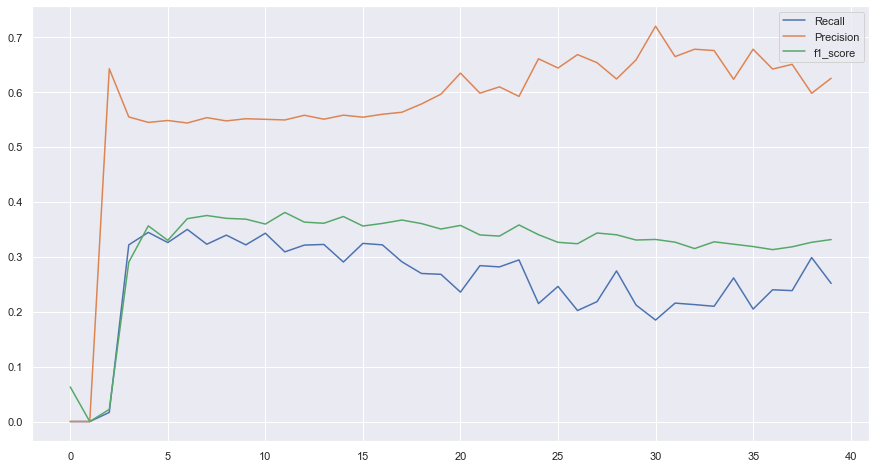

In [644]:
sns.set(rc=rcParams)
plt.plot(model.history.history["val_recall"])
plt.plot(model.history.history["val_precision"])
plt.plot(model.history.history["f1_m"])
plt.legend(["Recall", "Precision", "f1_score"])

In [645]:
# Confusion Matrix
# Keras use 0.5 as threshold
# The reason is that predict method itself returns the probability of membership of the input to each class. 
# If the last layer is softmax then the probability which is used would be mutually exclusive membership
y_pred = model.predict(val_features)
# Transforming probabilities to binary
y_pred = np.array([1 if y > 0.5 else 0 for y in y_pred])
# np.unique(y_pred, return_counts=True)
np.bincount(y_pred), np.bincount(val_target.reshape(-1)),

(array([8331, 1044], dtype=int64), array([6780, 2595], dtype=int64))

SERIE 0.7509333333333333 0.7667746969151362 0.9421828908554573 0.8454768049765072
EXCITACAO 0.7509333333333333 0.6245210727969349 0.251252408477842 0.3583402033525694


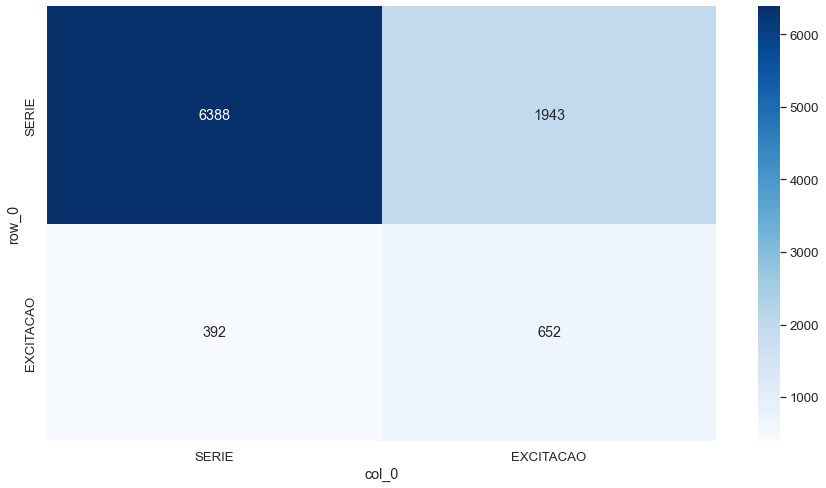

In [646]:
# https://www.youtube.com/watch?v=zqJLLaDd4QQ&t=551s
sns.set(font_scale=1.2)
confusion_df = pd.crosstab(y_pred, val_target.reshape(-1)).rename(columns=faults_type_dic, index=faults_type_dic)
sns.heatmap(confusion_df, annot=True, cmap='Blues', fmt='g')
for i in range(confusion_df.shape[0]):
    TP = confusion_df.iloc[i,i]
    FP = confusion_df.iloc[i, :].sum() - TP
    FN = confusion_df.iloc[:, i].sum() - TP
    TN = confusion_df.sum().sum() - TP -FP - FN
    Accuracy = (TP+TN)/confusion_df.sum().sum()
    Precision = TP/(TP+FP)
    Recall = TP/(TP+FN)
    F1_Score = (2*Precision*Recall)/(Precision+Recall)
    print(confusion_df.index[i], Accuracy, Precision, Recall, F1_Score)

**Treinando com uma funcao de loss de crossentropia**

Na teoria da informacao a entropia cruzada se refere à diferença entre duas distribuições de probabilidade p (verdadeira) e q (estimada) sobre o mesmo conjunto de eventos. Na prática a entropia cruzada mede o número de bits necessários para identificar um evento.


In [647]:
# Treinando com uma funcao de loss de crossentropia
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.BinaryAccuracy(name="accuracy"),
    f1_m
]

model.compile(optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=metrics)

model.fit(
    train_features,
    train_target,
    batch_size=2048,
    epochs=40,
    verbose=2,
    validation_data=(val_features, val_target)
)

Epoch 1/40
19/19 - 2s - loss: 0.5128 - fn: 8709.0000 - fp: 1014.0000 - tn: 25686.0000 - tp: 2088.0000 - precision: 0.6731 - recall: 0.1934 - accuracy: 0.7407 - f1_m: 0.2999 - val_loss: 0.4834 - val_fn: 1912.0000 - val_fp: 402.0000 - val_tn: 6378.0000 - val_tp: 683.0000 - val_precision: 0.6295 - val_recall: 0.2632 - val_accuracy: 0.7532 - val_f1_m: 0.3701 - 2s/epoch - 106ms/step
Epoch 2/40
19/19 - 0s - loss: 0.4988 - fn: 8482.0000 - fp: 1086.0000 - tn: 25614.0000 - tp: 2315.0000 - precision: 0.6807 - recall: 0.2144 - accuracy: 0.7448 - f1_m: 0.3260 - val_loss: 0.4830 - val_fn: 2078.0000 - val_fp: 228.0000 - val_tn: 6552.0000 - val_tp: 517.0000 - val_precision: 0.6940 - val_recall: 0.1992 - val_accuracy: 0.7540 - val_f1_m: 0.3065 - 103ms/epoch - 5ms/step
Epoch 3/40
19/19 - 0s - loss: 0.4958 - fn: 8603.0000 - fp: 1013.0000 - tn: 25687.0000 - tp: 2194.0000 - precision: 0.6841 - recall: 0.2032 - accuracy: 0.7436 - f1_m: 0.3146 - val_loss: 0.4843 - val_fn: 1851.0000 - val_fp: 467.0000 - val_

Epoch 23/40
19/19 - 0s - loss: 0.4913 - fn: 8754.0000 - fp: 823.0000 - tn: 25877.0000 - tp: 2043.0000 - precision: 0.7128 - recall: 0.1892 - accuracy: 0.7446 - f1_m: 0.2986 - val_loss: 0.4823 - val_fn: 2167.0000 - val_fp: 142.0000 - val_tn: 6638.0000 - val_tp: 428.0000 - val_precision: 0.7509 - val_recall: 0.1649 - val_accuracy: 0.7537 - val_f1_m: 0.2674 - 83ms/epoch - 4ms/step
Epoch 24/40
19/19 - 0s - loss: 0.4938 - fn: 8971.0000 - fp: 691.0000 - tn: 26009.0000 - tp: 1826.0000 - precision: 0.7255 - recall: 0.1691 - accuracy: 0.7423 - f1_m: 0.2770 - val_loss: 0.4750 - val_fn: 2060.0000 - val_fp: 255.0000 - val_tn: 6525.0000 - val_tp: 535.0000 - val_precision: 0.6772 - val_recall: 0.2062 - val_accuracy: 0.7531 - val_f1_m: 0.3133 - 78ms/epoch - 4ms/step
Epoch 25/40
19/19 - 0s - loss: 0.4897 - fn: 8780.0000 - fp: 846.0000 - tn: 25854.0000 - tp: 2017.0000 - precision: 0.7045 - recall: 0.1868 - accuracy: 0.7433 - f1_m: 0.2948 - val_loss: 0.4770 - val_fn: 2018.0000 - val_fp: 313.0000 - val_t

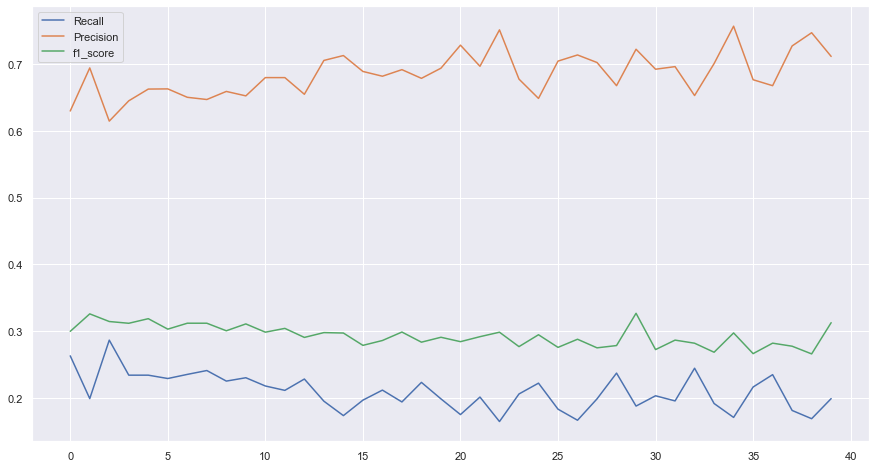

In [648]:
sns.set(rc=rcParams)
plt.plot(model.history.history["val_recall"])
plt.plot(model.history.history["val_precision"])
plt.plot(model.history.history["f1_m"])
plt.legend(["Recall", "Precision", "f1_score"])

In [649]:
# Confusion Matrix
# Keras use 0.5 as threshold
# The reason is that predict method itself returns the probability of membership of the input to each class. 
# If the last layer is softmax then the probability which is used would be mutually exclusive membership
y_pred = model.predict(val_features)
# Transforming probabilities to binary
y_pred = np.array([1 if y > 0.5 else 0 for y in y_pred])
# np.unique(y_pred, return_counts=True)
np.bincount(y_pred), np.bincount(val_target.reshape(-1)),

(array([8648,  727], dtype=int64), array([6780, 2595], dtype=int64))

SERIE 0.7559466666666667 0.759713228492137 0.9690265486725663 0.8516982110448535
EXCITACAO 0.7559466666666667 0.7111416781292985 0.19922928709055876 0.3112582781456954


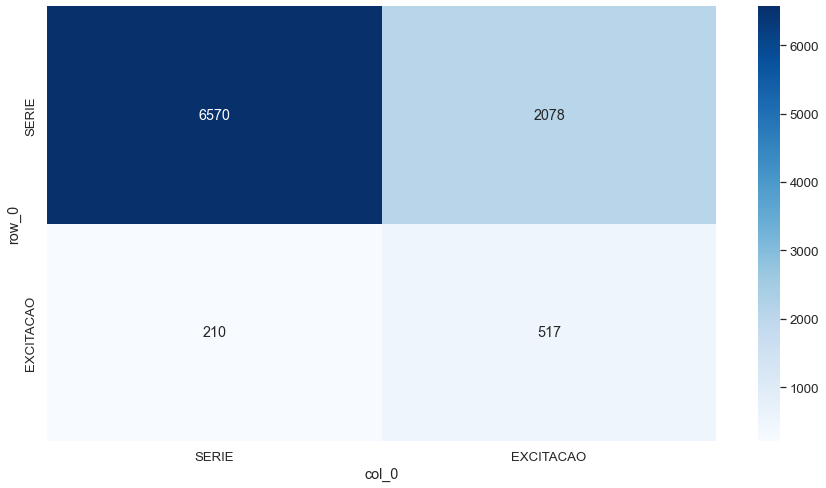

In [650]:
# https://www.youtube.com/watch?v=zqJLLaDd4QQ&t=551s
sns.set(font_scale=1.2)
confusion_df = pd.crosstab(y_pred, val_target.reshape(-1)).rename(columns=faults_type_dic, index=faults_type_dic)
sns.heatmap(confusion_df, annot=True, cmap='Blues', fmt='g')
for i in range(confusion_df.shape[0]):
    TP = confusion_df.iloc[i,i]
    FP = confusion_df.iloc[i, :].sum() - TP
    FN = confusion_df.iloc[:, i].sum() - TP
    TN = confusion_df.sum().sum() - TP -FP - FN
    Accuracy = (TP+TN)/confusion_df.sum().sum()
    Precision = TP/(TP+FP)
    Recall = TP/(TP+FN)
    F1_Score = (2*Precision*Recall)/(Precision+Recall)
    print(confusion_df.index[i], Accuracy, Precision, Recall, F1_Score)

**Treinando com uma funcao de loss DKL**

In [651]:
# Treinando com uma funcao de loss DKL
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.BinaryAccuracy(name="accuracy"),
    f1_m
]

model.compile(optimizer=keras.optimizers.Adam(1e-2), loss="KLDivergence", metrics=metrics)


model.fit(
    train_features,
    train_target,
    batch_size=2048,
    epochs=40,
    verbose=2,
    validation_data=(val_features, val_target)
)

Epoch 1/40
19/19 - 2s - loss: 0.0971 - fn: 2158.0000 - fp: 20276.0000 - tn: 6424.0000 - tp: 8639.0000 - precision: 0.2988 - recall: 0.8001 - accuracy: 0.4017 - f1_m: 0.4304 - val_loss: 0.0109 - val_fn: 0.0000e+00 - val_fp: 6780.0000 - val_tn: 0.0000e+00 - val_tp: 2595.0000 - val_precision: 0.2768 - val_recall: 1.0000 - val_accuracy: 0.2768 - val_f1_m: 0.4344 - 2s/epoch - 100ms/step
Epoch 2/40
19/19 - 0s - loss: 0.0191 - fn: 358.0000 - fp: 25793.0000 - tn: 907.0000 - tp: 10439.0000 - precision: 0.2881 - recall: 0.9668 - accuracy: 0.3026 - f1_m: 0.4434 - val_loss: 2.5463e-04 - val_fn: 0.0000e+00 - val_fp: 6780.0000 - val_tn: 0.0000e+00 - val_tp: 2595.0000 - val_precision: 0.2768 - val_recall: 1.0000 - val_accuracy: 0.2768 - val_f1_m: 0.4344 - 83ms/epoch - 4ms/step
Epoch 3/40
19/19 - 0s - loss: 0.0064 - fn: 176.0000 - fp: 26223.0000 - tn: 477.0000 - tp: 10621.0000 - precision: 0.2883 - recall: 0.9837 - accuracy: 0.2960 - f1_m: 0.4457 - val_loss: -6.4019e-07 - val_fn: 0.0000e+00 - val_fp: 

Epoch 23/40
19/19 - 0s - loss: 4.2407e-05 - fn: 1.0000 - fp: 26693.0000 - tn: 7.0000 - tp: 10796.0000 - precision: 0.2880 - recall: 0.9999 - accuracy: 0.2881 - f1_m: 0.4479 - val_loss: -1.1657e-06 - val_fn: 0.0000e+00 - val_fp: 6780.0000 - val_tn: 0.0000e+00 - val_tp: 2595.0000 - val_precision: 0.2768 - val_recall: 1.0000 - val_accuracy: 0.2768 - val_f1_m: 0.4344 - 76ms/epoch - 4ms/step
Epoch 24/40
19/19 - 0s - loss: 4.6484e-05 - fn: 2.0000 - fp: 26698.0000 - tn: 2.0000 - tp: 10795.0000 - precision: 0.2879 - recall: 0.9998 - accuracy: 0.2879 - f1_m: 0.4465 - val_loss: -1.1657e-06 - val_fn: 0.0000e+00 - val_fp: 6780.0000 - val_tn: 0.0000e+00 - val_tp: 2595.0000 - val_precision: 0.2768 - val_recall: 1.0000 - val_accuracy: 0.2768 - val_f1_m: 0.4344 - 77ms/epoch - 4ms/step
Epoch 25/40
19/19 - 0s - loss: 5.3481e-05 - fn: 2.0000 - fp: 26694.0000 - tn: 6.0000 - tp: 10795.0000 - precision: 0.2880 - recall: 0.9998 - accuracy: 0.2880 - f1_m: 0.4472 - val_loss: -1.1657e-06 - val_fn: 0.0000e+00 - 

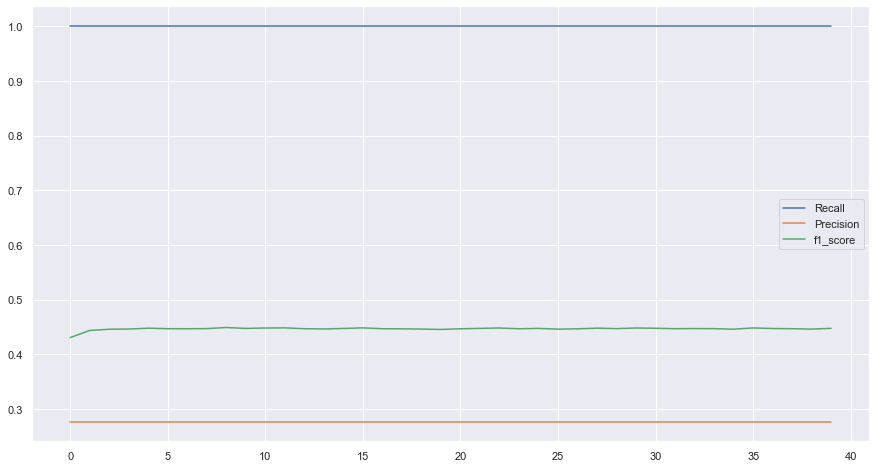

In [652]:
sns.set(rc=rcParams)
plt.plot(model.history.history["val_recall"])
plt.plot(model.history.history["val_precision"])
plt.plot(model.history.history["f1_m"])
plt.legend(["Recall", "Precision", "f1_score"])

In [653]:
# Confusion Matrix
# Keras use 0.5 as threshold
# The reason is that predict method itself returns the probability of membership of the input to each class. 
# If the last layer is softmax then the probability which is used would be mutually exclusive membership
y_pred = model.predict(val_features)
# Transforming probabilities to binary
y_pred = np.array([1 if y > 0.5 else 0 for y in y_pred])
# np.unique(y_pred, return_counts=True)
np.bincount(y_pred), np.bincount(val_target.reshape(-1)),

(array([   0, 9375], dtype=int64), array([6780, 2595], dtype=int64))

EXCITACAO 0.7232 0.7232 1.0 0.8393686165273909


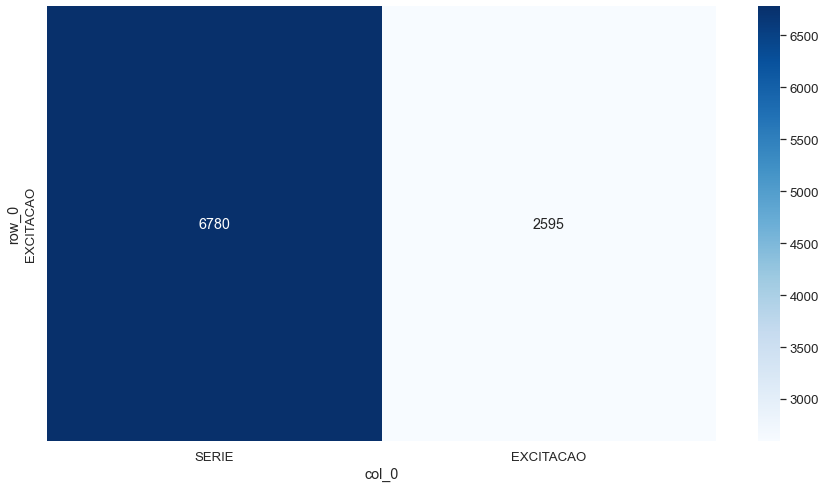

In [654]:
# https://www.youtube.com/watch?v=zqJLLaDd4QQ&t=551s
sns.set(font_scale=1.2)
confusion_df = pd.crosstab(y_pred, val_target.reshape(-1)).rename(columns=faults_type_dic, index=faults_type_dic)
sns.heatmap(confusion_df, annot=True, cmap='Blues', fmt='g')
for i in range(confusion_df.shape[0]):
    TP = confusion_df.iloc[i,i]
    FP = confusion_df.iloc[i, :].sum() - TP
    FN = confusion_df.iloc[:, i].sum() - TP
    TN = confusion_df.sum().sum() - TP -FP - FN
    Accuracy = (TP+TN)/confusion_df.sum().sum()
    Precision = TP/(TP+FP)
    Recall = TP/(TP+FN)
    F1_Score = (2*Precision*Recall)/(Precision+Recall)
    print(confusion_df.index[i], Accuracy, Precision, Recall, F1_Score)

In [655]:
accuracy = np.diag(confusion_df).sum() / confusion_df.sum().sum()
precision = confusion_df.iloc[0,0] / confusion_df.iloc[:, :1].sum()
accuracy

0.7232